In [1]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from typing import List
np.set_printoptions(threshold=np.inf)  

from fragment import *
from side import *
from sides_comparison import *
from utils import *
from puzzle import *
import global_values
from displaying import *
from groups import *


In [2]:
image_path = "disney_puzzle/aladin.jpg" 
# image_path = "angry.jpg"
output_folder = "fragments"
global_values.COL_NR = 8
global_values.ROW_NR = 8
fragments, tile_h, tile_w = divide_image(image_path, output_folder, global_values.COL_NR, global_values.ROW_NR)
global_values.TILE_H = global_values.TILE_W = max(tile_h, tile_w)

sides_comparisons = create_sides_comparisons(fragments)



sorted_sides_comparisons = sort_sides_comparisons(sides_comparisons)

n = len(fragments)
s = 4  
global_values.SYMMETRIC_COMPARISONS = [[[[None for _ in range(s)] for _ in range(s)] for _ in range(n)] for _ in range(n)]

for c in sides_comparisons:
    global_values.SYMMETRIC_COMPARISONS[c.side1.fragment_idx][c.side2.fragment_idx][c.side1.side_idx][c.side2.side_idx] = c
    symmetric_comp = SidesComparison(fragments, c.side2, c.side1)
    global_values.SYMMETRIC_COMPARISONS[c.side2.fragment_idx][c.side1.fragment_idx][c.side2.side_idx][c.side1.side_idx] = symmetric_comp



100%|██████████| 63/63 [00:00<00:00, 104.05it/s]


In [3]:
import numpy as np

# Example 2D array
arr = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])

# Rotate 90° clockwise (1 time counter-clockwise → 270° clockwise)
rotated_once = np.rot90(arr, k=3)

# Rotate 180°
rotated_twice = np.rot90(arr, k=2)

# Rotate 270° clockwise (1 time counter-clockwise)
rotated_thrice = np.rot90(arr, k=1)

print(rotated_once)


[[7 4 1]
 [8 5 2]
 [9 6 3]]


In [4]:
groups = []
fragment_idx_to_group_idx = [None for _ in fragments]

for fr_idx in range(len(fragments)):
    new_group = Group(fr_idx)
    groups.append(new_group)
    fragment_idx_to_group_idx[fr_idx] = fr_idx
# show_all_groups(groups, fragments)
print(fragment_idx_to_group_idx)



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]


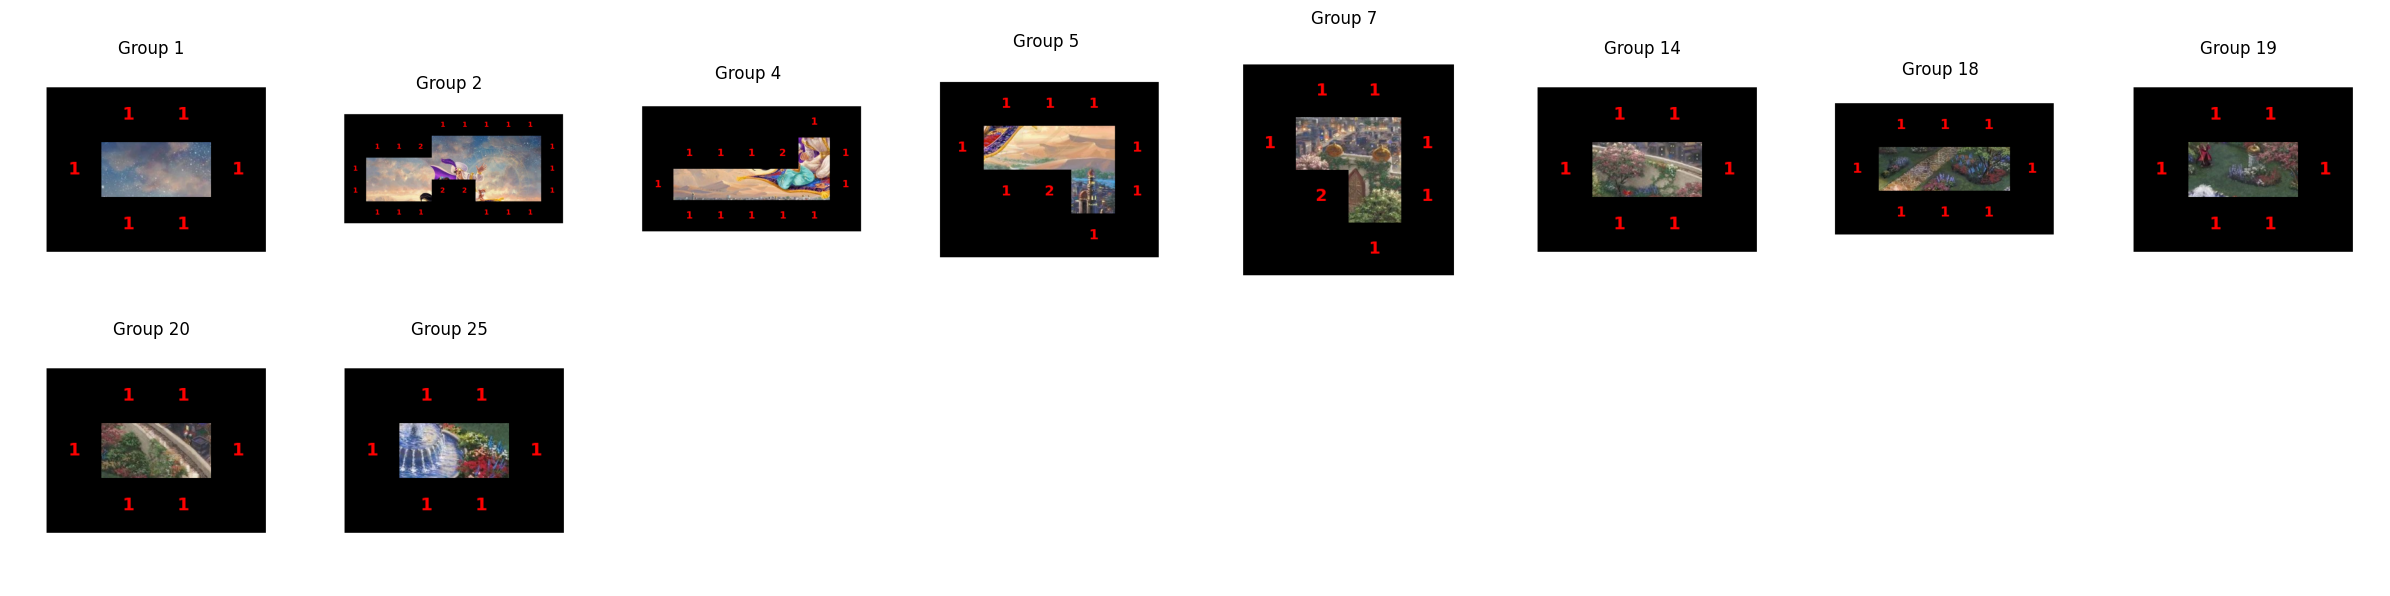

{0: [1, 1]}
{1: [1, 1], 2: [1, 2]}
{8: [2, 1], 3: [1, 4], 9: [2, 2], 16: [3, 1], 17: [3, 2], 18: [3, 3], 10: [2, 3], 11: [2, 4], 4: [1, 5], 5: [1, 6], 6: [1, 7], 7: [1, 8], 12: [2, 5], 13: [2, 6], 21: [3, 6], 14: [2, 7], 22: [3, 7], 15: [2, 8], 23: [3, 8]}
{19: [1, 1]}
{24: [2, 1], 25: [2, 2], 26: [2, 3], 27: [2, 4], 20: [1, 5], 28: [2, 5]}
{29: [1, 1], 30: [1, 2], 31: [1, 3], 39: [2, 3]}
{32: [1, 1]}
{33: [1, 1], 34: [1, 2], 42: [2, 2]}
{35: [1, 1]}
{36: [1, 1]}
{37: [1, 1]}
{38: [1, 1]}
{40: [1, 1]}
{41: [1, 1]}
{43: [1, 1], 44: [1, 2]}
{45: [1, 1]}
{46: [1, 1]}
{47: [1, 1]}
{48: [1, 1], 49: [1, 2], 50: [1, 3]}
{51: [1, 1], 52: [1, 2]}
{53: [1, 1], 54: [1, 2]}
{55: [1, 1]}
{56: [1, 1]}
{57: [1, 1]}
{58: [1, 1]}
{59: [1, 1], 60: [1, 2]}
{61: [1, 1]}
{62: [1, 1]}
{63: [1, 1]}


In [ ]:
for comp in sorted_sides_comparisons:
    if comp.score < 0.2:

        anchor_fragment_idx = comp.side1.fragment_idx
        pasted_fragment_idx = comp.side2.fragment_idx
        anchor_group_idx = fragment_idx_to_group_idx[anchor_fragment_idx]
        pasted_group_idx = fragment_idx_to_group_idx[pasted_fragment_idx]

        if anchor_group_idx != pasted_group_idx:

            shifted_anchor_group, shifted_pasted_group = simulate_merge_positions(comp, groups[anchor_group_idx], groups[pasted_group_idx])

            if does_merge_fit_within_bounds(shifted_anchor_group):
                if check_groups_shapes_for_merging(shifted_anchor_group, shifted_pasted_group):
                    if check_all_group_matchings_scores(shifted_anchor_group, shifted_pasted_group):     
                        groups[anchor_group_idx] = merge_groups(shifted_anchor_group, shifted_pasted_group, fragment_idx_to_group_idx)
                        update_after_merge(groups, fragments, fragment_idx_to_group_idx, pasted_group_idx)
show_all_groups(groups, fragments, fragment_idx_to_group_idx, 1)

for g in groups:
    print(g.fragment_positions)

Merged group 5 and 11 using: Sides Comp: Score=0.04896098173664514 Fragment_idx1=30, Side_idx1=2; fragment_idx2=38, side_idx2=0
Merged group 2 and 1 using: Sides Comp: Score=0.02737505801484275 Fragment_idx1=10, Side_idx1=0; fragment_idx2=2, side_idx2=2
Merged group 1 and 0 using: Sides Comp: Score=0.04850720875083761 Fragment_idx1=8, Side_idx1=0; fragment_idx2=0, side_idx2=2
Merged group 3 and 8 using: Sides Comp: Score=0.5101277857259932 Fragment_idx1=29, Side_idx1=2; fragment_idx2=37, side_idx2=0
Merged group 0 and 1 using: Sides Comp: Score=7.637443965231852 Fragment_idx1=11, Side_idx1=2; fragment_idx2=19, side_idx2=0
Merged group 0 and 1 using: Sides Comp: Score=0.9080561792863635 Fragment_idx1=12, Side_idx1=2; fragment_idx2=20, side_idx2=0
Merged group 3 and 7 using: Sides Comp: Score=2498.806215196757 Fragment_idx1=33, Side_idx1=2; fragment_idx2=41, side_idx2=0
Merged group 0 and 1 using: Sides Comp: Score=1622288435622.264 Fragment_idx1=21, Side_idx1=2; fragment_idx2=29, side_i

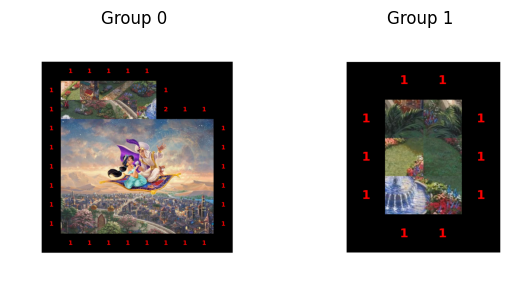

In [ ]:
groups, fragments, fragment_idx_to_group_idx = solve_groups(groups, fragments, fragment_idx_to_group_idx)
show_all_groups(groups, fragments, fragment_idx_to_group_idx, 0)


